In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_parquet("C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

In [3]:
df.head()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,0,2020-01-22T16:55:53.000Z,NaN,1,8.0,1998-02-07T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,4.0,0,10.0,1.0,1963-01-01T00:00:00.000Z,1997-01-11T00:00:00.000Z,NaN,NaN,NaN,0,7,0,200000.0,50000.0,1998,0,382.0,0,0.00,937.0,1,N,NaN,0,0.0,NaN,0.0,None,612.0,NaN,0.0,0,Pineapple Express - Southern,15000.0,0.0,60294.0,None,"OCEANSIDE, CITY OF",97.0,1.0,1.0,937.0,NaN,A,0,0.0,None,NaN,0,CA,Currently Unavailable,92056.0,6073.0,6.073019e+09,6.073019e+10,33.2,-117.3,4053d562-94c7-4155-9d60-3030f34a7abc
1,0,2020-01-22T16:55:53.000Z,NaN,1,8.0,2005-08-29T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,NaN,1.0,1967-07-01T00:00:00.000Z,1990-07-12T00:00:00.000Z,NaN,NaN,NaN,0,7,0,100000.0,40000.0,2005,1,NaN,0,0.00,NaN,1,N,NaN,0,0.0,NaN,0.0,None,654.0,NaN,0.0,0,Hurricane Katrina,30000.0,0.0,225203.0,None,NEW ORLEANS/ORLEANS PARISH*,6.0,6.0,1.0,NaN,NaN,A,0,0.0,None,NaN,0,LA,Currently Unavailable,70131.0,22071.0,2.207100e+10,2.207100e+11,29.9,-90.0,4094445e-bc54-42b2-a60d-b949bdc2df3a
2,0,2020-01-22T16:55:53.000Z,NaN,1,9.0,1998-09-28T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,10.0,1.0,1972-01-01T00:00:00.000Z,1997-07-24T00:00:00.000Z,8813.21,1720.0,0.0,0,1,0,100000.0,50000.0,1998,1,9313.0,0,8813.21,80000.0,1,N,2220.0,0,1720.0,0.0,0.0,None,133.0,NaN,0.0,0,Hurricane Georges (Panhandle),15000.0,0.0,120274.0,None,SANTA ROSA COUNTY *,NaN,NaN,1.0,100000.0,0.0,A,0,0.0,None,NaN,0,FL,Currently Unavailable,32566.0,12113.0,1.211301e+10,1.211301e+11,30.4,-86.9,659ba8e0-1bb3-4442-ad57-3f384db43176
3,0,2019-09-19T13:45:58.000Z,1.0,1,9.0,1994-10-07T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,10.0,1.0,1960-01-01T00:00:00.000Z,1993-10-01T00:00:00.000Z,2906.00,0.0,0.0,0,7,0,100000.0,25000.0,1994,0,4428.0,0,2906.00,100000.0,1,N,NaN,0,0.0,NaN,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,450026.0,None,"BEAUFORT, CITY OF",97.0,NaN,1.0,0.0,NaN,A,0,0.0,None,NaN,0,SC,Currently Unavailable,29902.0,45013.0,4.501300e+10,4.501300e+11,32.4,-80.7,97063578-59b6-403d-b9c3-2e70fd8b6f38
4,0,2019-09-19T13:45:58.000Z,NaN,1,8.0,1996-03-11T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1988-01-01T00:00:00.000Z,1996-01-11T00:00:00.000Z,3875.53,1545.0,0.0,1,7,0,100000.0,25000.0,1996,1,5252.0,0,3875.53,100000.0,1,N,3115.0,0,1545.0,0.0,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,125092.0,None,BREVARD COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,613c20ef-7838-48ee-a257-07a49e997d3a


## Data filtering and creation of new variables

In [4]:
# dropping extreme and creating outcome variable relative_damage

df['buildingrelativeDamage'] = df['buildingDamageAmount']/df['buildingPropertyValue']

df['buildingrelativeDamage'].replace([np.inf, -np.inf], np.nan, inplace=True)

df_filtered = df[(df['buildingrelativeDamage'] <= 1.2) & (df['buildingrelativeDamage'] >= 0)]

#cap relative damage at 1
df_filtered.loc[df_filtered['buildingrelativeDamage'] > 1, 'buildingrelativeDamage'] = 1



In [5]:
# filtering the dataset to be residential type (1,2,3), number of floor to be 1, Main House (1), water depth < 6

df_filtered = df_filtered[df_filtered['numberOfFloorsInTheInsuredBuilding'] == 1.0]
df_filtered = df_filtered[df_filtered['occupancyType'].isin([1.0, 2.0, 3.0])]
df_filtered = df_filtered[df_filtered['buildingDescriptionCode'] == 1.0]
df_filtered = df_filtered[(df_filtered['waterDepth'] < 6) & (df_filtered['waterDepth'] >= 0)]

print(f'Size of the dataset \nbefore filtering: {df.shape[0]} \nafter filtering {df_filtered.shape[0]} \ndifference: {df.shape[0] - df_filtered.shape[0]}')

Size of the dataset 
before filtering: 2597460 
after filtering 210108 
difference: 2387352


In [6]:
df_filtered

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id,buildingrelativeDamage
4,0,2019-09-19T13:45:58.000Z,NaN,1,8.0,1996-03-11T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1988-01-01T00:00:00.000Z,1996-01-11T00:00:00.000Z,3875.53,1545.00,0.0,1,7,0,100000.0,25000.0,1996,1,5252.0,0,3875.53,100000.0,1,N,3115.0,0,1545.00,0.0,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,125092.0,None,BREVARD COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,613c20ef-7838-48ee-a257-07a49e997d3a,0.052520
115,0,2020-01-22T16:55:53.000Z,NaN,1,9.0,2009-11-12T00:00:00.000Z,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1952-07-01T00:00:00.000Z,2008-08-04T00:00:00.000Z,2611.46,0.00,0.0,0,1,0,150000.0,0.0,2009,0,3111.0,0,2611.46,37260.0,1,N,NaN,0,0.00,NaN,0.0,None,247.0,NaN,0.0,0,Nor'easter,30000.0,0.0,510104.0,510104,"NORFOLK, CITY OF",NaN,NaN,1.0,113263.0,NaN,A,0,1.0,A04,1.0,0,VA,Currently Unavailable,23505.0,51710.0,5.171000e+10,5.171000e+11,36.9,-76.3,dfa5355d-0761-41ee-a77b-fd5467bc981b,0.083494
118,0,2020-01-22T16:55:53.000Z,NaN,1,7.0,2004-09-16T00:00:00.000Z,0,None,NaN,NaN,C,0,3.0,NaN,NaN,1.0,0,NaN,1.0,1966-07-01T00:00:00.000Z,1976-04-08T00:00:00.000Z,1747.80,184.80,0.0,0,1,0,239300.0,45300.0,2004,1,2247.0,0,1747.80,191440.0,1,N,684.0,0,184.80,0.0,0.0,None,643.0,NaN,0.0,0,Hurricane Ivan,30000.0,0.0,120274.0,120274,SANTA ROSA COUNTY *,NaN,NaN,0.0,239300.0,0.0,A,0,0.0,AE,1.0,0,FL,Currently Unavailable,32583.0,12113.0,1.211301e+10,1.211301e+11,30.6,-87.0,6ecc0bf9-25df-48c7-b72b-a52446b895c5,0.011737
141,0,2020-01-22T16:55:53.000Z,NaN,1,8.0,2004-09-15T00:00:00.000Z,0,None,4.0,7.0,AE,0,NaN,NaN,11.0,1.0,0,NaN,1.0,1948-07-01T00:00:00.000Z,1987-04-01T00:00:00.000Z,65129.73,26825.14,0.0,0,1,0,102500.0,44800.0,2004,1,65630.0,0,65129.73,82000.0,1,N,27325.0,0,26825.14,0.0,0.0,None,643.0,NaN,0.0,0,Hurricane Ivan,30000.0,0.0,120080.0,None,ESCAMBIA COUNTY*,NaN,NaN,0.0,102500.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32507.0,12033.0,1.203300e+10,1.203300e+11,30.4,-87.3,fca538d9-e1bf-49b7-b051-73c761f2c9aa,0.800366
160,0,2019-09-19T13:45:58.000Z,NaN,1,9.0,1996-09-05T00:00:00.000Z,0,None,3.0,11.0,AE,0,NaN,NaN,13.6,1.0,0,NaN,1.0,1979-11-14T00:00:00.000Z,1987-07-02T00:00:00.000Z,4347.47,0.00,0.0,1,1,0,73700.0,4300.0,1996,0,5202.0,0,4347.47,73700.0,1,N,NaN,0,0.00,NaN,0.0,None,592.0,NaN,0.0,0,Hurricane Fran,NaN,0.0,370187.0,None,"TOPSAIL BEACH, TOWN OF",97.0,NaN,0.0,0.0,NaN,A,0,0.0,None,1.0,0,NC,Currently Unavailable,28445.0,37141.0,3.714192e+10,3.714192e+11,34.4,-77.6,f

In [7]:
# Convert all relevant columns to datetime
df_filtered['dateOfLoss'] = pd.to_datetime(df_filtered['dateOfLoss'], errors='coerce')
df_filtered['originalConstructionDate_pddatetime'] = pd.to_datetime(df_filtered['originalConstructionDate'], errors='coerce')
df_filtered['originalNBDate_pddatetime'] = pd.to_datetime(df_filtered['originalNBDate'], errors='coerce')

# Calculate the age of the building and the policy until the flood
df_filtered['AgeofBuildinguntilflood'] = (df_filtered['dateOfLoss'] - df_filtered['originalConstructionDate_pddatetime']).dt.days / 365.25
df_filtered['AgeofPolicyuntilflood'] = (df_filtered['dateOfLoss'] - df_filtered['originalNBDate_pddatetime']).dt.days / 365.25

# If you need the ages as whole numbers, you can round or floor them
df_filtered['AgeofBuildinguntilflood'] = df_filtered['AgeofBuildinguntilflood'].round().astype('Int64')
df_filtered['AgeofPolicyuntilflood'] = df_filtered['AgeofPolicyuntilflood'].round().astype('Int64')


In [8]:
df_filtered.head()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id,buildingrelativeDamage,originalConstructionDate_pddatetime,originalNBDate_pddatetime,AgeofBuildinguntilflood,AgeofPolicyuntilflood
4,0,2019-09-19T13:45:58.000Z,NaN,1,8.0,1996-03-11 00:00:00+00:00,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1988-01-01T00:00:00.000Z,1996-01-11T00:00:00.000Z,3875.53,1545.00,0.0,1,7,0,100000.0,25000.0,1996,1,5252.0,0,3875.53,100000.0,1,N,3115.0,0,1545.00,0.0,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,125092.0,None,BREVARD COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,613c20ef-7838-48ee-a257-07a49e997d3a,0.052520,1988-01-01 00:00:00+00:00,1996-01-11 00:00:00+00:00,8,0
115,0,2020-01-22T16:55:53.000Z,NaN,1,9.0,2009-11-12 00:00:00+00:00,0,None,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1952-07-01T00:00:00.000Z,2008-08-04T00:00:00.000Z,2611.46,0.00,0.0,0,1,0,150000.0,0.0,2009,0,3111.0,0,2611.46,37260.0,1,N,NaN,0,0.00,NaN,0.0,None,247.0,NaN,0.0,0,Nor'easter,30000.0,0.0,510104.0,510104,"NORFOLK, CITY OF",NaN,NaN,1.0,113263.0,NaN,A,0,1.0,A04,1.0,0,VA,Currently Unavailable,23505.0,51710.0,5.171000e+10,5.171000e+11,36.9,-76.3,dfa5355d-0761-41ee-a77b-fd5467bc981b,0.083494,1952-07-01 00:00:00+00:00,2008-08-04 00:00:00+00:00,57,1
118,0,2020-01-22T16:55:53.000Z,NaN,1,7.0,2004-09-16 00:00:00+00:00,0,None,NaN,NaN,C,0,3.0,NaN,NaN,1.0,0,NaN,1.0,1966-07-01T00:00:00.000Z,1976-04-08T00:00:00.000Z,1747.80,184.80,0.0,0,1,0,239300.0,45300.0,2004,1,2247.0,0,1747.80,191440.0,1,N,684.0,0,184.80,0.0,0.0,None,643.0,NaN,0.0,0,Hurricane Ivan,30000.0,0.0,120274.0,120274,SANTA ROSA COUNTY *,NaN,NaN,0.0,239300.0,0.0,A,0,0.0,AE,1.0,0,FL,Currently Unavailable,32583.0,12113.0,1.211301e+10,1.211301e+11,30.6,-87.0,6ecc0bf9-25df-48c7-b72b-a52446b895c5,0.011737,1966-07-01 00:00:00+00:00,1976-04-08 00:00:00+00:00,38,28
141,0,2020-01-22T16:55:53.000Z,NaN,1,8.0,2004-09-15 00:00:00+00:00,0,None,4.0,7.0,AE,0,NaN,NaN,11.0,1.0,0,NaN,1.0,1948-07-01T00:00:00.000Z,1987-04-01T00:00:00.000Z,65129.73,26825.14,0.0,0,1,0,102500.0,44800.0,2004,1,65630.0,0,65129.73,82000.0,1,N,27325.0,0,26825.14,0.0,0.0,None,643.0,NaN,0.0,0,Hurricane Ivan,30000.0,0.0,120080.0,None,ESCAMBIA COUNTY*,NaN,NaN,0.0,102500.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32507.0,12033.0,1.203300e+10,1.203300e+11,30.4,-87.3,fca538d9-e1bf-49b7-b051-73c761f2c9aa,0.800366,1948-07-01 00:00:00+00:00,1987-04-01 00:00:00+00:00,56,17
160,0,2019-09-19T13:45:58.000Z,NaN,1,9.0,1996-09-05 00:00:00+00:00,0,None,3.0,11.0,AE,0,NaN,NaN,13.6,1.0,0,NaN,1.0,197

### Variable selection and check for missing data

In [9]:
variables_to_keep = [
    'elevatedBuildingIndicator',
    'elevationDifference',
    'baseFloodElevation',
    'ratedFloodZone',
    'occupancyType',
    'rateMethod',
    'crsClassificationCode',
    'elevationCertificateIndicator',
    'lowestFloorElevation',
    'lowestAdjacentGrade',
    'totalBuildingInsuranceCoverage',
    'totalContentsInsuranceCoverage',
    'primaryResidenceIndicator',
    'buildingPropertyValue',
    'causeOfDamage',
    'contentsPropertyValue',
    'disasterAssistanceCoverageRequired',
    'floodCharacteristicsIndicator',
    'floodproofedIndicator',
    'buildingReplacementCost',
    'contentsReplacementCost',
    'waterDepth',
    'floodZoneCurrent',
    'rentalPropertyIndicator',
    'postFIRMConstructionIndicator',
    'buildingrelativeDamage',
    'AgeofBuildinguntilflood',
    'AgeofPolicyuntilflood',
    'reportedZipCode',
    'countyCode',
    'censusTract',
    'censusBlockGroupFips',
    'latitude',
    'longitude',
    'state',
    'yearOfLoss'
]

df_filtered_subset = df_filtered[variables_to_keep]


In [10]:
df_filtered_subset.head()

,elevatedBuildingIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,occupancyType,rateMethod,crsClassificationCode,elevationCertificateIndicator,lowestFloorElevation,lowestAdjacentGrade,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,contentsPropertyValue,disasterAssistanceCoverageRequired,floodCharacteristicsIndicator,floodproofedIndicator,buildingReplacementCost,contentsReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss
4,0,NaN,NaN,X,1.0,7,8.0,None,NaN,NaN,100000.0,25000.0,1,100000.0,1,0.0,0.0,NaN,0,0.0,0.0,0.0,None,0,1,0.052520,8,0,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,FL,1996
115,0,NaN,NaN,X,1.0,1,9.0,None,NaN,NaN,150000.0,0.0,0,37260.0,1,NaN,0.0,NaN,0,113263.0,NaN,1.0,A04,0,0,0.083494,57,1,23505.0,51710.0,5.171000e+10,5.171000e+11,36.9,-76.3,VA,2009
118,0,NaN,NaN,C,1.0,1,7.0,None,NaN,NaN,239300.0,45300.0,1,191440.0,1,0.0,0.0,NaN,0,239300.0,0.0,0.0,AE,0,0,0.011737,38,28,32583.0,12113.0,1.211301e+10,1.211301e+11,30.6,-87.0,FL,2004
141,0,4.0,7.0,AE,1.0,1,8.0,None,11.0,NaN,102500.0,44800.0,1,82000.0,1,0.0,0.0,NaN,0,102500.0,0.0,0.0,None,0,0,0.800366,56,17,32507.0,12033.0,1.203300e+10,1.203300e+11,30.4,-87.3,FL,2004
160,0,3.0,11.0,AE,1.0,1,9.0,None,13.6,NaN,73700.0,4300.0,0,73700.0,1,NaN,0.0,NaN,0,0.0,NaN,0.0,None,0,1,0.070583,17,9,28445.0,37141.0,3.714192e+10,3.714192e+11,34.4,-77.6,NC,1996


## Reading and exploring geographic features

In [11]:
df_geographic_info = pd.read_csv("C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/svdGeographicVariablesWithMergeData.csv")

In [12]:
df_geographic_info.head()

,Unnamed: 0,original_index,reportedZipCode_x,countyCode_x,censusTract_x,censusBlockGroupFips_x,latitude_x,longitude_x,state_x,centroid_lat_x,centroid_long_x,h3,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,reportedZipCode_y,countyCode_y,censusTract_y,censusBlockGroupFips_y,latitude_y,longitude_y,state_y,centroid_lat_y,centroid_long_y,year
0,0,0,92056,6073,6073018512,6.073019e+10,33.2,-117.3,CA,33.211862,-117.329977,8729a4294ffffff,1.774546,-1.103126,1.768020,-1.870246,-0.248187,1.374362,0.472315,1.187354,-1.982219,-1.824606,1.320108,-0.988220,0.104402,0.024751,-0.283559,0.418063,0.083397,1.116887,-0.603207,0.050379,0.929021,0.547388,-1.343377,0.344710,-0.313406,0.816226,0.491136,0.639307,0.006972,-0.124356,92056,6073,6073018512,60730185123,33.2,-117.3,CA,33.211862,-117.329978,1998
1,1,1,70131,22071,22071000616,2.207100e+11,29.9,-90.0,LA,29.918024,-89.997074,874446434ffffff,-0.363733,0.023164,-0.246714,0.226464,-0.230780,-0.644696,-0.128062,-0.214082,-0.770155,0.160270,0.065145,-0.065367,0.237029,-0.042192,0.596184,-1.616988,-0.441110,-0.827110,0.782143,-0.073584,0.467571,0.269655,0.020166,0.392584,0.328875,-0.003107,0.083614,-0.176460,-0.011863,0.095398,70131,22071,22071000616,220710006163,29.9,-90.0,LA,29.918024,-89.997074,2005
2,2,2,32566,12113,12113010815,1.211300e+11,30.4,-86.9,FL,30.392125,-86.930936,8744566c6ffffff,-0.487226,-0.190240,0.364396,-0.159709,-0.029696,-0.322152,0.834244,-0.014280,0.002545,-0.167933,-0.294170,2.041984,-2.373367,2.755253,-1.145958,-0.706078,0.918923,-0.506325,0.066679,-1.304258,0.407962,-2.432443,-0.501994,0.299886,-0.187492,0.220293,-0.809364,-1.113802,2.519074,-1.544782,32566,12113,12113010815,121130108152,30.4,-86.9,FL,30.392125,-86.930936,1998
3,3,3,29902,45013,45013000700,4.501300e+11,32.4,-80.7,SC,32.434712,-80.682657,8744d0b2cffffff,-0.483802,-0.165186,0.291715,0.077179,0.214199,-0.944381,2.282067,-0.332673,0.296988,0.422363,-0.325333,-2.923128,-0.801495,1.646409,3.526368,0.792007,-0.965128,0.313162,-1.618442,0.387545,-1.055773,0.660428,-0.989053,-0.456151,0.072725,-0.060861,0.354814,-0.208954,0.406184,-0.132717,29902,45013,45013000700,450130007002,32.4,-80.7,SC,32.434712,-80.682657,1994
4,4,4,32940,12009,12009063107,1.200910e+11,28.3,-80.7,FL,28.257577,-80.700013,8744a82caffffff,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402,32940,12009,12009063107,120090631073,28.3,-80.7,FL,28.257577,-80.700013,1996


In [13]:
df_geographic_info = df_geographic_info.drop(columns=['Unnamed: 0', 'original_index', 'h3'])
df_geographic_info = df_geographic_info.rename(columns={
    'year': 'yearOfLoss',
    'reportedZipCode_y': 'reportedZipCode',
    'countyCode_y': 'countyCode',
    'censusTract_y': 'censusTract',
    'censusBlockGroupFips_y': 'censusBlockGroupFips',
    'latitude_y': 'latitude',
    'longitude_y': 'longitude',
    'state_y': 'state',
    'centroid_lat_y': 'centroid_lat',
    'centroid_long_y': 'centroid_long'
})


In [14]:
df_geographic_info.head()

,reportedZipCode_x,countyCode_x,censusTract_x,censusBlockGroupFips_x,latitude_x,longitude_x,state_x,centroid_lat_x,centroid_long_x,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,centroid_lat,centroid_long,yearOfLoss
0,92056,6073,6073018512,6.073019e+10,33.2,-117.3,CA,33.211862,-117.329977,1.774546,-1.103126,1.768020,-1.870246,-0.248187,1.374362,0.472315,1.187354,-1.982219,-1.824606,1.320108,-0.988220,0.104402,0.024751,-0.283559,0.418063,0.083397,1.116887,-0.603207,0.050379,0.929021,0.547388,-1.343377,0.344710,-0.313406,0.816226,0.491136,0.639307,0.006972,-0.124356,92056,6073,6073018512,60730185123,33.2,-117.3,CA,33.211862,-117.329978,1998
1,70131,22071,22071000616,2.207100e+11,29.9,-90.0,LA,29.918024,-89.997074,-0.363733,0.023164,-0.246714,0.226464,-0.230780,-0.644696,-0.128062,-0.214082,-0.770155,0.160270,0.065145,-0.065367,0.237029,-0.042192,0.596184,-1.616988,-0.441110,-0.827110,0.782143,-0.073584,0.467571,0.269655,0.020166,0.392584,0.328875,-0.003107,0.083614,-0.176460,-0.011863,0.095398,70131,22071,22071000616,220710006163,29.9,-90.0,LA,29.918024,-89.997074,2005
2,32566,12113,12113010815,1.211300e+11,30.4,-86.9,FL,30.392125,-86.930936,-0.487226,-0.190240,0.364396,-0.159709,-0.029696,-0.322152,0.834244,-0.014280,0.002545,-0.167933,-0.294170,2.041984,-2.373367,2.755253,-1.145958,-0.706078,0.918923,-0.506325,0.066679,-1.304258,0.407962,-2.432443,-0.501994,0.299886,-0.187492,0.220293,-0.809364,-1.113802,2.519074,-1.544782,32566,12113,12113010815,121130108152,30.4,-86.9,FL,30.392125,-86.930936,1998
3,29902,45013,45013000700,4.501300e+11,32.4,-80.7,SC,32.434712,-80.682657,-0.483802,-0.165186,0.291715,0.077179,0.214199,-0.944381,2.282067,-0.332673,0.296988,0.422363,-0.325333,-2.923128,-0.801495,1.646409,3.526368,0.792007,-0.965128,0.313162,-1.618442,0.387545,-1.055773,0.660428,-0.989053,-0.456151,0.072725,-0.060861,0.354814,-0.208954,0.406184,-0.132717,29902,45013,45013000700,450130007002,32.4,-80.7,SC,32.434712,-80.682657,1994
4,32940,12009,12009063107,1.200910e+11,28.3,-80.7,FL,28.257577,-80.700013,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402,32940,12009,12009063107,120090631073,28.3,-80.7,FL,28.257577,-80.700013,1996


### Mapping both the datasets using the geographic information

In [15]:
# preprocessing

df_filtered_subset['reportedZipCode'] = df_filtered_subset['reportedZipCode'].fillna(0)
df_filtered_subset['countyCode'] = df_filtered_subset['countyCode'].fillna(0)
df_filtered_subset['censusTract'] = df_filtered_subset['censusTract'].fillna(0)
df_filtered_subset['censusBlockGroupFips'] = df_filtered_subset['censusBlockGroupFips'].fillna(0)
df_filtered_subset['latitude'] = df_filtered_subset['latitude'].fillna(0)
df_filtered_subset['longitude'] = df_filtered_subset['longitude'].fillna(0)

df_filtered_subset['reportedZipCode'] = df_filtered_subset['reportedZipCode'].astype(int).astype(str)
df_filtered_subset['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_filtered_subset['reportedZipCode']]

df_filtered_subset['censusBlockGroupFips'] = [str(int(float(i))) for i in df_filtered_subset['censusBlockGroupFips']]
df_filtered_subset['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_filtered_subset['censusBlockGroupFips']]

df_filtered_subset['countyCode'] = [str(int(float(i))) for i in df_filtered_subset['countyCode']]
df_filtered_subset['countyCode'] = [censusBG.zfill(5) for censusBG in df_filtered_subset['countyCode']]

df_filtered_subset['censusTract'] = [str(int(float(i))) for i in df_filtered_subset['censusTract']]
df_filtered_subset['censusTract'] = [censusBG.zfill(11) for censusBG in df_filtered_subset['censusTract']]

C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\583733578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset['reportedZipCode'] = df_filtered_subset['reportedZipCode'].fillna(0)
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\583733578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset['countyCode'] = df_filtered_subset['countyCode'].fillna(0)
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\583733578.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [16]:
# preprocessing

df_geographic_info['reportedZipCode'] = df_geographic_info['reportedZipCode'].fillna(0)
df_geographic_info['countyCode'] = df_geographic_info['countyCode'].fillna(0)
df_geographic_info['censusTract'] = df_geographic_info['censusTract'].fillna(0)
df_geographic_info['censusBlockGroupFips'] = df_geographic_info['censusBlockGroupFips'].fillna(0)
df_geographic_info['latitude'] = df_geographic_info['latitude'].fillna(0)
df_geographic_info['longitude'] = df_geographic_info['longitude'].fillna(0)

df_geographic_info['reportedZipCode'] = df_geographic_info['reportedZipCode'].astype(int).astype(str)
df_geographic_info['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_geographic_info['reportedZipCode']]

df_geographic_info['censusBlockGroupFips'] = [str(int(float(i))) for i in df_geographic_info['censusBlockGroupFips']]
df_geographic_info['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_geographic_info['censusBlockGroupFips']]

df_geographic_info['countyCode'] = [str(int(float(i))) for i in df_geographic_info['countyCode']]
df_geographic_info['countyCode'] = [censusBG.zfill(5) for censusBG in df_geographic_info['countyCode']]

df_geographic_info['censusTract'] = [str(int(float(i))) for i in df_geographic_info['censusTract']]
df_geographic_info['censusTract'] = [censusBG.zfill(11) for censusBG in df_geographic_info['censusTract']]

In [17]:
df_geographic_info.head()

,reportedZipCode_x,countyCode_x,censusTract_x,censusBlockGroupFips_x,latitude_x,longitude_x,state_x,centroid_lat_x,centroid_long_x,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,centroid_lat,centroid_long,yearOfLoss
0,92056,6073,6073018512,6.073019e+10,33.2,-117.3,CA,33.211862,-117.329977,1.774546,-1.103126,1.768020,-1.870246,-0.248187,1.374362,0.472315,1.187354,-1.982219,-1.824606,1.320108,-0.988220,0.104402,0.024751,-0.283559,0.418063,0.083397,1.116887,-0.603207,0.050379,0.929021,0.547388,-1.343377,0.344710,-0.313406,0.816226,0.491136,0.639307,0.006972,-0.124356,92056,06073,06073018512,060730185123,33.2,-117.3,CA,33.211862,-117.329978,1998
1,70131,22071,22071000616,2.207100e+11,29.9,-90.0,LA,29.918024,-89.997074,-0.363733,0.023164,-0.246714,0.226464,-0.230780,-0.644696,-0.128062,-0.214082,-0.770155,0.160270,0.065145,-0.065367,0.237029,-0.042192,0.596184,-1.616988,-0.441110,-0.827110,0.782143,-0.073584,0.467571,0.269655,0.020166,0.392584,0.328875,-0.003107,0.083614,-0.176460,-0.011863,0.095398,70131,22071,22071000616,220710006163,29.9,-90.0,LA,29.918024,-89.997074,2005
2,32566,12113,12113010815,1.211300e+11,30.4,-86.9,FL,30.392125,-86.930936,-0.487226,-0.190240,0.364396,-0.159709,-0.029696,-0.322152,0.834244,-0.014280,0.002545,-0.167933,-0.294170,2.041984,-2.373367,2.755253,-1.145958,-0.706078,0.918923,-0.506325,0.066679,-1.304258,0.407962,-2.432443,-0.501994,0.299886,-0.187492,0.220293,-0.809364,-1.113802,2.519074,-1.544782,32566,12113,12113010815,121130108152,30.4,-86.9,FL,30.392125,-86.930936,1998
3,29902,45013,45013000700,4.501300e+11,32.4,-80.7,SC,32.434712,-80.682657,-0.483802,-0.165186,0.291715,0.077179,0.214199,-0.944381,2.282067,-0.332673,0.296988,0.422363,-0.325333,-2.923128,-0.801495,1.646409,3.526368,0.792007,-0.965128,0.313162,-1.618442,0.387545,-1.055773,0.660428,-0.989053,-0.456151,0.072725,-0.060861,0.354814,-0.208954,0.406184,-0.132717,29902,45013,45013000700,450130007002,32.4,-80.7,SC,32.434712,-80.682657,1994
4,32940,12009,12009063107,1.200910e+11,28.3,-80.7,FL,28.257577,-80.700013,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402,32940,12009,12009063107,120090631073,28.3,-80.7,FL,28.257577,-80.700013,1996


In [18]:
mapping_columns = [
    'reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips',
    'latitude', 'longitude', 'state', 'yearOfLoss']

df_filtered_subset.set_index(mapping_columns, inplace=True)
df_geographic_info.set_index(mapping_columns, inplace=True)

In [19]:
svd_columns = [f'svd_{i}' for i in range(1, 31)]

df_geographic_info_svd = df_geographic_info[svd_columns]

In [20]:
for svd_col in svd_columns:
    df_filtered_subset[svd_col] = df_filtered_subset.index.map(df_geographic_info_svd[svd_col])

C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset[svd_col] = df_filtered_subset.index.map(df_geographic_info_svd[svd_col])
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset[svd_col] = df_filtered_subset.index.map(df_geographic_info_svd[svd_col])
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is tryin

C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset[svd_col] = df_filtered_subset.index.map(df_geographic_info_svd[svd_col])
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_subset[svd_col] = df_filtered_subset.index.map(df_geographic_info_svd[svd_col])
C:\Users\jorda\AppData\Local\Temp\ipykernel_21044\57212599.py:2: SettingWithCopyWarning: 
A value is tryin

In [21]:
df_filtered_subset.reset_index(inplace=True)
df_geographic_info.reset_index(inplace=True)
df_geographic_info_svd.reset_index(inplace=True)

In [22]:
df_filtered_subset.shape[0]

210108

In [23]:
df_filtered_subset.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss,elevatedBuildingIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,occupancyType,rateMethod,crsClassificationCode,elevationCertificateIndicator,lowestFloorElevation,lowestAdjacentGrade,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,contentsPropertyValue,disasterAssistanceCoverageRequired,floodCharacteristicsIndicator,floodproofedIndicator,buildingReplacementCost,contentsReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,32940,12009,12009063107,120090631073,28.3,-80.7,FL,1996,0,NaN,NaN,X,1.0,7,8.0,None,NaN,NaN,100000.0,25000.0,1,100000.0,1,0.0,0.0,NaN,0,0.0,0.0,0.0,None,0,1,0.052520,8,0,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402
1,23505,51710,51710001200,517100012001,36.9,-76.3,VA,2009,0,NaN,NaN,X,1.0,1,9.0,None,NaN,NaN,150000.0,0.0,0,37260.0,1,NaN,0.0,NaN,0,113263.0,NaN,1.0,A04,0,0,0.083494,57,1,-0.440167,-0.026508,-0.265916,-0.101934,-0.578929,-0.273033,-0.381519,-0.066282,-0.761965,-0.364831,-0.789079,2.972900,-1.743709,4.187647,-1.028620,0.660021,0.302219,0.764221,-1.073185,-2.093600,0.419692,3.275569,-1.975996,-1.032234,22.982420,-3.494600,-1.374440,2.460046,9.894575,-4.918725
2,32583,12113,12113010809,121130108091,30.6,-87.0,FL,2004,0,NaN,NaN,C,1.0,1,7.0,None,NaN,NaN,239300.0,45300.0,1,191440.0,1,0.0,0.0,NaN,0,239300.0,0.0,0.0,AE,0,0,0.011737,38,28,-0.487011,-0.178706,0.300662,-0.180206,-0.122099,-0.252817,0.428306,0.024471,-0.140899,-0.029402,-0.572798,-0.472122,0.110230,-0.315755,-0.226288,-0.048457,-0.005177,-0.584027,1.562803,-0.141775,0.261002,-0.439834,-0.024958,0.928115,-0.028791,-0.085646,0.008390,0.015467,0.285856,-0.134586
3,32507,12033,12033002300,120330023004,30.4,-87.3,FL,2004,0,4.0,7.0,AE,1.0,1,8.0,None,11.0,NaN,102500.0,44800.0,1,82000.0,1,0.0,0.0,NaN,0,102500.0,0.0,0.0,None,0,0,0.800366,56,17,-0.389182,-0.143250,0.341384,-0.081046,0.291763,-0.666212,1.571670,-0.164597,0.058252,0.231910,0.912889,-0.768089,0.094755,0.005752,0.353880,-1.412354,1.136864,0.353490,1.320365,-0.010683,-0.476934,-0.085460,0.244494,-0.964397,0.431071,-0.234543,-0.055565,-0.255935,0.248011,-0.083549
4,28445,37141,37141920101,371419201011,34.4,-77.6,NC,1996,0,3.0,11.0,AE,1.0,1,9.0,None,13.6,NaN,73700.0,4300.0,0,73700.0,1,NaN,0.0,NaN,0,0.0,NaN,0.0,None,0,1,0.070583,17,9,-0.572386,-0.142794,0.306223,0.106274,0.035533,-0.221587,0.990321,-0.207453,0.470000,0.379363,1.012849,0.526264,0.347955,-0.959901,0.987863,0.029553,0.721367,0.199539,-0.391917,0.175819,-2.181929,0.966825,-0.223965,-0.775800,-0.592636,0.068290,-0.039304,0.535170,0.338631,-0.260381


In [24]:
# Step 1: Filter for rows where both columns are not null
not_null_subset = df_filtered_subset.dropna(subset=['ratedFloodZone', 'floodZoneCurrent'])

# Step 2: Calculate the percentage of these rows where the two columns match
matches = (not_null_subset['ratedFloodZone'] == not_null_subset['floodZoneCurrent']).mean() * 100

print(f"Percentage of matching 'ratedFloodZone' and 'floodZoneCurrent' (when both are not null): {matches:.2f}%")


Percentage of matching 'ratedFloodZone' and 'floodZoneCurrent' (when both are not null): 94.10%


In [25]:
# Impute missing 'floodZoneCurrent' with 'ratedFloodZone' values when 'ratedFloodZone' is not missing
df_filtered_subset.loc[df_filtered_subset['floodZoneCurrent'].isna() & df_filtered_subset['ratedFloodZone'].notna(), 'floodZoneCurrent'] = df_filtered_subset.loc[df_filtered_subset['floodZoneCurrent'].isna() & df_filtered_subset['ratedFloodZone'].notna(), 'ratedFloodZone']



In [26]:
sum(df_filtered_subset['floodZoneCurrent'].isna())

23

In [27]:
# Drop rows where 'floodZoneCurrent' is NaN
df_filtered_subset = df_filtered_subset.dropna(subset=['floodZoneCurrent'])

print(f"Remaining rows after dropping: {len(df_filtered_subset)}")


Remaining rows after dropping: 210085


In [28]:
# Since we are trying to evaluate geo_info columns, hence dropping the rows with NaN values 3.1% of the dataset  
# (all these are coastal locations, will resolve it by insteresting the geographic unit with continental US shapefile)

svd_columns = [f'svd_{i}' for i in range(1, 31)]

df_filtered_subset.dropna(subset=svd_columns, inplace=True)

In [29]:
print(f'\nAbsolute numbers:\n\n{df_filtered_subset.isna().sum()}')
print(f'\npercentage of the total data:\n\n{df_filtered_subset.isna().sum()*100/df_filtered_subset.shape[0]}')


Absolute numbers:

reportedZipCode         0
countyCode              0
censusTract             0
censusBlockGroupFips    0
latitude                0
                       ..
svd_26                  0
svd_27                  0
svd_28                  0
svd_29                  0
svd_30                  0
Length: 66, dtype: int64

percentage of the total data:

reportedZipCode         0.0
countyCode              0.0
censusTract             0.0
censusBlockGroupFips    0.0
latitude                0.0
                       ... 
svd_26                  0.0
svd_27                  0.0
svd_28                  0.0
svd_29                  0.0
svd_30                  0.0
Length: 66, dtype: float64


In [30]:
len(df_filtered_subset)

203557

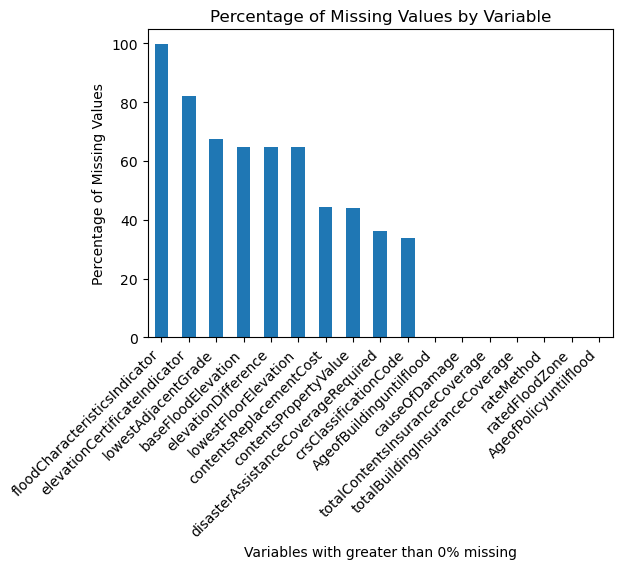

floodCharacteristicsIndicator         99.771563
elevationCertificateIndicator         82.032551
lowestAdjacentGrade                   67.476923
baseFloodElevation                    64.923830
elevationDifference                   64.761222
lowestFloorElevation                  64.712587
contentsReplacementCost               44.263278
contentsPropertyValue                 44.116390
disasterAssistanceCoverageRequired    36.213444
crsClassificationCode                 33.808712
AgeofBuildinguntilflood                0.038810
causeOfDamage                          0.031441
totalContentsInsuranceCoverage         0.007860
totalBuildingInsuranceCoverage         0.007369
rateMethod                             0.007369
ratedFloodZone                         0.001474
AgeofPolicyuntilflood                  0.000983
dtype: float64


In [31]:
missing_percent = df_filtered_subset.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0]

missing_percent.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
missing_percent.plot.bar()
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables with greater than 0% missing')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")
plt.show()

print(missing_percent)

In [32]:
# List of column names to drop
columns_to_drop = [
    'floodCharacteristicsIndicator',
    'elevationCertificateIndicator',
    'lowestAdjacentGrade',
    'baseFloodElevation',
    'elevationDifference',
    'lowestFloorElevation',
    'contentsReplacementCost',
    'contentsPropertyValue',
    'disasterAssistanceCoverageRequired',
    'crsClassificationCode'
]

# Drop the columns from df_filtered_subset
df_filtered_subset = df_filtered_subset.drop(columns=columns_to_drop)

print("Columns dropped.")


Columns dropped.


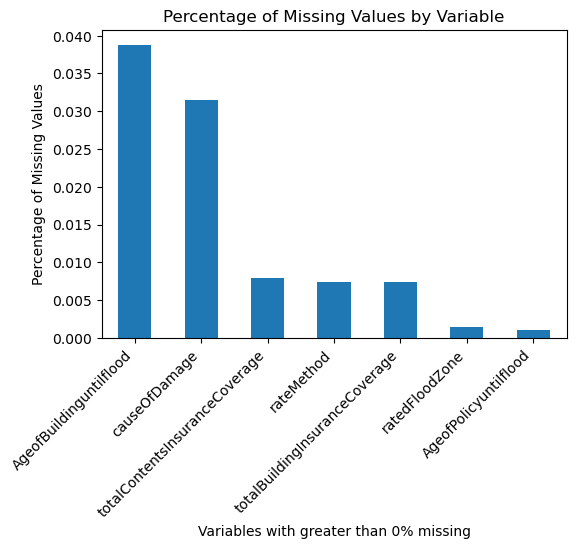

AgeofBuildinguntilflood           0.038810
causeOfDamage                     0.031441
totalContentsInsuranceCoverage    0.007860
rateMethod                        0.007369
totalBuildingInsuranceCoverage    0.007369
ratedFloodZone                    0.001474
AgeofPolicyuntilflood             0.000983
dtype: float64


In [33]:
missing_percent = df_filtered_subset.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0]

missing_percent.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
missing_percent.plot.bar()
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables with greater than 0% missing')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")
plt.show()

print(missing_percent)

In [34]:
df_filtered_subset.to_parquet(f"C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/filtered_dataset_version2_with_geo_info.parquet.gzip", compression='gzip')

In [35]:
df_filtered_subset.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss,elevatedBuildingIndicator,ratedFloodZone,occupancyType,rateMethod,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,floodproofedIndicator,buildingReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,32940,12009,12009063107,120090631073,28.3,-80.7,FL,1996,0,X,1.0,7,100000.0,25000.0,1,100000.0,1,0,0.0,0.0,X,0,1,0.052520,8,0,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402
1,23505,51710,51710001200,517100012001,36.9,-76.3,VA,2009,0,X,1.0,1,150000.0,0.0,0,37260.0,1,0,113263.0,1.0,A04,0,0,0.083494,57,1,-0.440167,-0.026508,-0.265916,-0.101934,-0.578929,-0.273033,-0.381519,-0.066282,-0.761965,-0.364831,-0.789079,2.972900,-1.743709,4.187647,-1.028620,0.660021,0.302219,0.764221,-1.073185,-2.093600,0.419692,3.275569,-1.975996,-1.032234,22.982420,-3.494600,-1.374440,2.460046,9.894575,-4.918725
2,32583,12113,12113010809,121130108091,30.6,-87.0,FL,2004,0,C,1.0,1,239300.0,45300.0,1,191440.0,1,0,239300.0,0.0,AE,0,0,0.011737,38,28,-0.487011,-0.178706,0.300662,-0.180206,-0.122099,-0.252817,0.428306,0.024471,-0.140899,-0.029402,-0.572798,-0.472122,0.110230,-0.315755,-0.226288,-0.048457,-0.005177,-0.584027,1.562803,-0.141775,0.261002,-0.439834,-0.024958,0.928115,-0.028791,-0.085646,0.008390,0.015467,0.285856,-0.134586
3,32507,12033,12033002300,120330023004,30.4,-87.3,FL,2004,0,AE,1.0,1,102500.0,44800.0,1,82000.0,1,0,102500.0,0.0,AE,0,0,0.800366,56,17,-0.389182,-0.143250,0.341384,-0.081046,0.291763,-0.666212,1.571670,-0.164597,0.058252,0.231910,0.912889,-0.768089,0.094755,0.005752,0.353880,-1.412354,1.136864,0.353490,1.320365,-0.010683,-0.476934,-0.085460,0.244494,-0.964397,0.431071,-0.234543,-0.055565,-0.255935,0.248011,-0.083549
4,28445,37141,37141920101,371419201011,34.4,-77.6,NC,1996,0,AE,1.0,1,73700.0,4300.0,0,73700.0,1,0,0.0,0.0,AE,0,1,0.070583,17,9,-0.572386,-0.142794,0.306223,0.106274,0.035533,-0.221587,0.990321,-0.207453,0.470000,0.379363,1.012849,0.526264,0.347955,-0.959901,0.987863,0.029553,0.721367,0.199539,-0.391917,0.175819,-2.181929,0.966825,-0.223965,-0.775800,-0.592636,0.068290,-0.039304,0.535170,0.338631,-0.260381
